# Algoritmos Genéticos

    ▪Ramo dos algoritmos evolucionários
    ▪Técnica de busca baseada na metáfora do processo biológico de evolução natural.
    ▪Populações de indivíduos são criadas e submetidas aos operadores genéticos: 
        ▪Seleção;
        ▪Recombinação (crossover);
        ▪Mutação;
        ▪Elitismo.

# Minimizar a função x²+y².

![1](imagens/1.png)

### Modelando conjunto binário:

In [1]:
import numpy as np

class BitSet:
  def __init__(self, size):
    self.bits = np.full((1, size), False)

  def get(self, index):
    return self.bits[0, index]

  def set(self, index, value):
    self.bits[0, index] = value

  def flip(self, index):
    self.bits[0, index] = not self.bits[0, index]

  def debug(self):
    print(self.bits)

### Modelando o Cromossomo:

```
Genotípo com 10 bits:
  ##### #####
    |     |_ valor de y.
    |_ valor de x.

Para cada variável: 4 bits para valor numérico e 1 bit para sinal (vvvvs).
Menor bit significativo a esquerda.
```

In [2]:
import random

class Chromossome:
  def __init__(self, x = None, y = None):
    '''
      Estancia o cromossomo com os valores de x e y (caso não sejam atribuidos são gerados valores aleatórios).
    '''
    if x == None:
      x = random.randint(-15, 15)

    if y == None:
      y = random.randint(-15, 15)

    self.__genes = Chromossome.get_genotype(x, y)

  def get_genes(self):
    return self.__genes

  def set_genes(self, genes):
    self.__genes = genes

  def __repr__(self):
    chr_str = "G = ["

    for i in range(10):
      chr_str += (i == 5 and " " or "") + (self.__genes.get(i) and "1" or "0")

    x, y = Chromossome.get_fenotype(self.__genes)

    chr_str += "], F = [" + str(x) + ", " + str(y) + "]"

    return chr_str

  @staticmethod
  def get_genotype(x, y):
    '''
      Método estático que retorna o genótipo dado o valor de x e y.
    '''
    bits = BitSet(10)

    xy_binary = "{:05b}".format(x) + "{:05b}".format(y)

    for i in range(10):
      bits.set(i, xy_binary[i] == '1')

    return bits

  @staticmethod
  def get_fenotype(genes):
    '''
      Método estático que retorna o valor de x e y dado o genótipo.
    '''
    x = (8 * genes.get(0) +
        4 * genes.get(1) +
        2 * genes.get(2) +
        1 * genes.get(3))

    if (genes.get(4) == 1):
        x *= -1

    y = (8 * genes.get(5) +
        4 * genes.get(6) +
        2 * genes.get(7) +
        1 * genes.get(8))

    if (genes.get(9) == 1):
        y *= -1

    return x, y

### Funções de avaliação do problema:

In [3]:
class Problem:
  @staticmethod
  def f(x, y):
    '''
      x²+y²
    '''
    return x**2 + y**2

  @staticmethod
  def f_chromossome(chromossome):
    '''
      Retorna f(x,y) dado o cromossomo.
    '''
    x, y = Chromossome.get_fenotype(chromossome.get_genes())
    return Problem.f(x, y)

  @staticmethod
  def g(x, y):
    '''
      1/(x²+y²) + 1
      Usado como função de fitness (função de avaliação).
      Valor varia de 0 à 1 e quanto mais próximo de 1, melhor.
    '''
    return 1 / (1 + Problem.f(x, y))

  @staticmethod
  def g_chromossome(chromossome):
    '''
      Retorna fitness dado o cromossomo.
    '''
    x, y = Chromossome.get_fenotype(chromossome.get_genes())
    return Problem.g(x, y)

  @staticmethod
  def f_average(population):
    '''
      Retorna a média de f(x,y) dos cromossomos dada a população.
    '''
    avg = 0
    for chromossome in population:
      avg += Problem.f_chromossome(chromossome)
    avg /= len(population)
    return avg

  @staticmethod
  def g_average(population):
    '''
      Retorna a média de fitness dos cromossomos dada a população.
    '''
    avg = 0
    for chromossome in population:
      x, y = chromossome.get_fenotype(chromossome.get_genes())
      avg += Problem.g(x, y)
    avg /= len(population)
    return avg

### Funções para operações com cromossomos:

In [4]:
class GeneticFunctions:
  @staticmethod
  def selection(population):
    '''
      Seleciona 2 cromossomos diferentes de forma aleatória.
    '''
    parent1 = random.choice(population)
    parent2 = random.choice(population)

    while parent1 is parent2:
      parent1 = random.choice(population)
      parent2 = random.choice(population)

    return parent1, parent2

  @staticmethod
  def crossover(population, parent1, parent2):
    '''
      Faz o cruzamento de 2 cromossomos, gerando 2 filhos e inserindo-os na população.
    '''
    crossover_point = random.randint(1, 9)

    parent1_genes = parent1.get_genes()
    parent2_genes = parent2.get_genes()

    child1_genes = BitSet(10)
    child2_genes = BitSet(10)

    for i in range(crossover_point):
      child1_genes.set(i, parent1_genes.get(i))
      child2_genes.set(i, parent2_genes.get(i))

    for i in range(crossover_point, 10):
      child1_genes.set(i, parent2_genes.get(i))
      child2_genes.set(i, parent1_genes.get(i))

    child1 = Chromossome()
    child1.set_genes(child1_genes)

    child2 = Chromossome()
    child2.set_genes(child2_genes)

    population.append(child1)
    population.append(child2)

    return crossover_point
      
  @staticmethod
  def mutation(population, mutation_prob):
    '''
      Gera mutação em 1 cromossomo aleatório da população dada a probabilidade de mutação.
    '''
    prob = random.uniform(0, 1)

    if prob < mutation_prob:
      target = random.choice(population)

      mutation_point = random.randint(0, 9)

      genes = target.get_genes()
      genes.flip(mutation_point)

      return True, mutation_point
    return False, None

  @staticmethod
  def elitism(population):
    '''
      Remove 2 dos piores cromossomos da população.
    '''
    for _ in range(2):
      worst_individual = GeneticFunctions.find_worst_chromossome(population)
      population.remove(worst_individual)
      
    return worst_individual

  @staticmethod
  def find_best_chromossome(population):
    '''
      Retorna o melhor cromossomo dada a população.
    '''
    best_chromossome = None

    for chromossome in population:
      score = Problem.g_chromossome(chromossome)

      if best_chromossome is None or score > Problem.g_chromossome(best_chromossome):
        best_chromossome = chromossome

    return best_chromossome

  @staticmethod
  def find_worst_chromossome(population):
    '''
      Retorna o pior cromossomo dada a população.
    '''
    worst_chromossome = None

    for chromossome in population:
      score = Problem.g_chromossome(chromossome)

      if worst_chromossome is None or score < Problem.g_chromossome(worst_chromossome):
        worst_chromossome = chromossome

    return worst_chromossome

### Execução:

In [5]:
def executar(tam_populacao, n_geracoes, prob_mutacao):
  populacao = []
  for _ in range(tam_populacao):
    populacao.append(Chromossome())

  pontuacoes = []
  pontuacao_inicial = Problem.g_average(populacao)
  pontuacoes.append(pontuacao_inicial)

  medias_f = []
  media_f_inicial = Problem.f_average(populacao)
  medias_f.append(media_f_inicial)

  for geracao in range(n_geracoes):
    pai1, pai2 = GeneticFunctions.selection(populacao)

    pos_crossover = GeneticFunctions.crossover(populacao, pai1, pai2)
    teve_mutacao, pos_mutacao = GeneticFunctions.mutation(populacao, prob_mutacao)
    pior_cromossomo = GeneticFunctions.elitism(populacao)
   
    pontuacao = Problem.g_average(populacao)
    pontuacoes.append(pontuacao)

    media_f = Problem.f_average(populacao)
    medias_f.append(media_f)

  melhor_cromossomo = GeneticFunctions.find_best_chromossome(populacao)
  
  return melhor_cromossomo, pontuacoes, medias_f

def executar_com_prints(tam_populacao, n_geracoes, prob_mutacao):
  populacao = []
  for _ in range(tam_populacao):
    populacao.append(Chromossome())

  print('População inicial:', populacao)

  pontuacoes = []
  pontuacao_inicial = Problem.g_average(populacao)
  pontuacoes.append(pontuacao_inicial)

  print('Pontuação inicial:', pontuacao_inicial)

  medias_f = []
  media_f_inicial = Problem.f_average(populacao)
  medias_f.append(media_f_inicial)

  print('Média de f(x,y) inicial:', media_f_inicial)

  for geracao in range(n_geracoes):
    print('Geração:', geracao)

    pai1, pai2 = GeneticFunctions.selection(populacao)
    print('\tSelecionados:', pai1, pai2)

    pos_crossover = GeneticFunctions.crossover(populacao, pai1, pai2)
    print('\tCrossover entre selecionados na posição:', pos_crossover)

    teve_mutacao, pos_mutacao = GeneticFunctions.mutation(populacao, prob_mutacao)
    print('\tTeve mutação? ', teve_mutacao)
    if(teve_mutacao):
      print('\t\tNa posição:', pos_mutacao)
    
    pior_cromossomo = GeneticFunctions.elitism(populacao)
    print('Foi eliminado o pior cromossomo:', pior_cromossomo, Problem.g_chromossome(pior_cromossomo))

    pontuacao = Problem.g_average(populacao)
    print(f'Pontuação da geração {geracao}:', pontuacao)

    media_f = Problem.f_average(populacao)
    medias_f.append(media_f)
    print(f'Média de f(x,y) da geração {geracao}:', media_f)

    pontuacoes.append(pontuacao)

  melhor_cromossomo = GeneticFunctions.find_best_chromossome(populacao)
  
  return melhor_cromossomo, pontuacoes, medias_f

melhor_cromossomo, pontuacoes, medias_f = executar_com_prints(
  tam_populacao=10,
  n_geracoes=50,
  prob_mutacao=0.05
)

print('Melhor cromossomo:', melhor_cromossomo, Problem.g_chromossome(melhor_cromossomo))

População inicial: [G = [00001 01110], F = [0, 7], G = [00000 01101], F = [0, -6], G = [00001 00100], F = [0, 2], G = [00010 01111], F = [1, -7], G = [00010 01000], F = [1, 4], G = [00000 00001], F = [0, 0], G = [01001 01110], F = [-4, 7], G = [01011 00100], F = [-5, 2], G = [01111 01000], F = [-7, 4], G = [00100 01111], F = [2, -7]]
Pontuação inicial: 0.14043453078747198
Média de f(x,y) inicial: 36.8
Geração: 0
	Selecionados: G = [00010 01000], F = [1, 4] G = [01001 01110], F = [-4, 7]
	Crossover entre selecionados na posição: 9
	Teve mutação?  False
Foi eliminado o pior cromossomo: G = [01111 01000], F = [-7, 4] 0.015151515151515152
Pontuação da geração 0: 0.14447493482787604
Média de f(x,y) da geração 0: 32.0
Geração: 1
	Selecionados: G = [00000 01101], F = [0, -6] G = [00001 00100], F = [0, 2]
	Crossover entre selecionados na posição: 7
	Teve mutação?  False
Foi eliminado o pior cromossomo: G = [00100 01111], F = [2, -7] 0.018518518518518517
Pontuação da geração 1: 0.16381063416357

### Plot do fitness por geração:

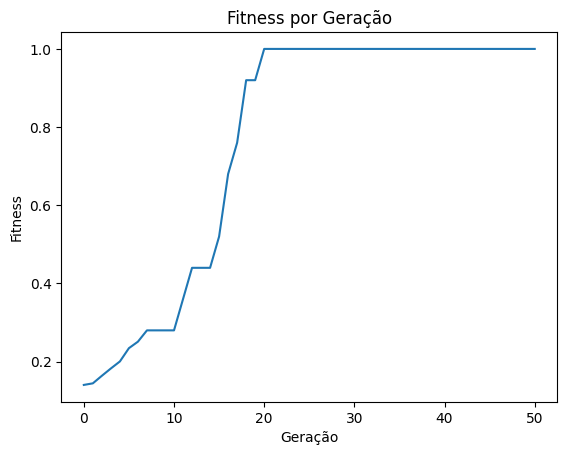

In [6]:
import matplotlib.pyplot as plt

plt.gca().set_xlabel('Geração')
plt.gca().set_ylabel('Fitness')
plt.gca().set_title('Fitness por Geração')
plt.plot(range(len(pontuacoes)), pontuacoes)
plt.show()

### Plot da média de f(x,y) por geração:

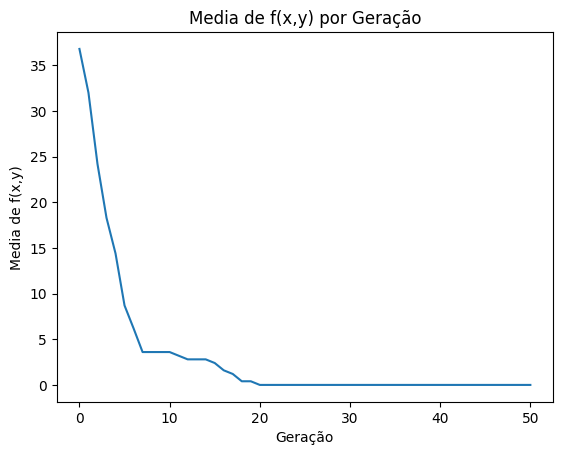

In [7]:
plt.gca().set_xlabel('Geração')
plt.gca().set_ylabel('Media de f(x,y)')
plt.gca().set_title('Media de f(x,y) por Geração')
plt.plot(range(len(medias_f)), medias_f)
plt.show()